# Coursera Capstone Project: The Battle of the Neighborhoods

### 1. The problem:

A client wants to open a new gym in Toronto and wants to know the best location to do so. The location can mean the difference between having a successful business and a failing one. The location will determine how many potential clients there are in the area and how much competition the business will have to deal with.

### 2. The Data:

The Toronto neighborhood data will be collected once again from the Wikipedia page on Toronto postal codes. The coordinates will be collected from the Geocoder package. Using the FourSquare API, the number of gyms in each neighborhood can be collected. Clustering the neighborhoods will allow us to determine the best cluster to place our gym in. 

### 3. Methodology:

i) Data collection (from Wikipedia, Geocoder, FourSquare) <br>
ii) Data cleaning <br>
iii) Clustering <br>

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

### Collecting neighborhood data from Wikipedia using BeautifulSoup:

In [2]:
raw_data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(raw_data,"html5lib")

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df = df[['PostalCode','Borough','Neighborhood']]

df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [3]:
df.shape

(103, 3)

### Getting coordinate data:

In [4]:
#Unable to use Geocoder package, I will use the provided csv file:
locations = pd.read_csv('Geospatial_Coordinates.csv')
locations.rename(columns={'Postal Code':'PostalCode'},inplace=True)
locations.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merging the 2 dataframes and Plotting Toronto Neighborhoods:

In [5]:
df = pd.merge(df,locations,on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [7]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

In [8]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [9]:
#!conda install -c conda-forge folium --yes
#!conda install -c conda-forge scikit-learn

import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

In [10]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

![Map 1](Figure_1.JPG)

### Get information for Foursquare api:

In [11]:
CLIENT_ID = 'client_id' # your Foursquare ID
CLIENT_SECRET = 'client_secret' # your Foursquare Secret
ACCESS_TOKEN = 'access_token' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius=500

### Define function to get nearby venues:

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Apply function to Toronto:

In [43]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [44]:
print(toronto_venues.shape)
toronto_venues.head()

(2141, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [45]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
Berczy Park,56,56,56,56,56,56
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16


### Creating a dataframe to get the venues in all the neighborhoods:

In [46]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
toronto_grouped.shape

(100, 271)

In [48]:
gyms = toronto_grouped[['Neighborhood','Gym']]
gyms.head()

,Neighborhood,Gym
0,Agincourt,0.000
1,"Alderwood, Long Branch",0.125
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000
3,Bayview Village,0.000
4,"Bedford Park, Lawrence Manor East",0.000


### KMeans Clustering

In [49]:
X = gyms[['Gym']]
X[0:5]

,Gym
0,0.000
1,0.125
2,0.000
3,0.000
4,0.000


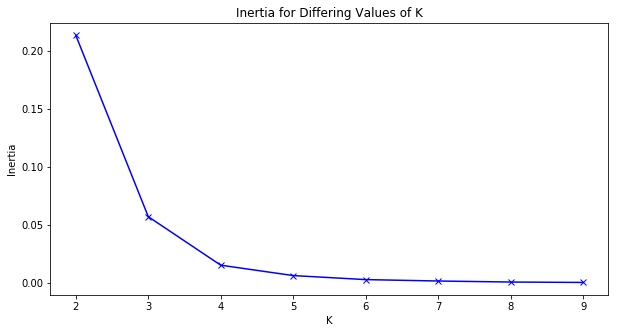

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 5])
inertia=[]
val=range(2,10)
for i in val:
  k_mean=KMeans(n_clusters=i)
  k_mean.fit_predict(X)
  inertia.append(k_mean.inertia_)
plt.plot(val,inertia,'bx-')
plt.xlabel('K') 
plt.ylabel('Inertia') 
plt.title('Inertia for Differing Values of K') 
plt.show()

We can see that the best K value occurs for K=3. We will proceed with this value

In [51]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = gyms.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Merging 

In [52]:
gyms['Cluster'] = kmeans.labels_ 

gyms = gyms.join(toronto_venues.set_index('Neighborhood'), on='Neighborhood')

gyms.head() # check the last columns!

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Gym,Cluster,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.000,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.000,0,43.794200,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.000,0,43.794200,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.000,0,43.794200,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
1,"Alderwood, Long Branch",0.125,0,43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place


In [53]:
gyms.sort_values(['Cluster'], inplace=True)

### Mapping neighborhood clusters:

In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(gyms['Neighborhood Latitude'], gyms['Neighborhood Longitude'], gyms['Neighborhood'], gyms['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

![Map 2](Figure_2.2.JPG)

### Cluster Analysis:

Cluster 1:

In [55]:
cluster_1 = gyms.loc[gyms['Cluster'] == 0]
cluster_1.head()

,Neighborhood,Gym,Cluster,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
66,Parkwoods,0.0,0,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
66,Parkwoods,0.0,0,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
65,"Parkview Hill, Woodbine Gardens",0.0,0,43.706397,-79.309937,TKTO - Toronto Knife Throwing Organization,43.709966,-79.313411,Athletics & Sports
65,"Parkview Hill, Woodbine Gardens",0.0,0,43.706397,-79.309937,Merchant's Flea Market,43.705108,-79.314168,Flea Market


Cluster 2:

In [56]:
cluster_2 = gyms.loc[gyms['Cluster'] == 1]
cluster_2.head()

,Neighborhood,Gym,Cluster,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
43,Humber Summit,1.0,1,43.756303,-79.565963,Faab Fitness,43.758156,-79.570442,Gym


Cluster 3:

In [57]:
cluster_3 = gyms.loc[gyms['Cluster'] == 2]
cluster_3.head()

,Neighborhood,Gym,Cluster,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
57,"Moore Park, Summerhill East",0.333333,2,43.689574,-79.383160,Ravine,43.690356,-79.386841,Trail
57,"Moore Park, Summerhill East",0.333333,2,43.689574,-79.383160,Totum Life Science St. Clair,43.686525,-79.383449,Gym
21,Don Mills North,0.250000,2,43.745906,-79.352188,Island Foods,43.745866,-79.346035,Caribbean Restaurant
21,Don Mills North,0.250000,2,43.745906,-79.352188,Baretto Caffé,43.744456,-79.346460,Café
21,Don Mills North,0.250000,2,43.745906,-79.352188,Gonoe Sushi,43.745737,-79.345991,Japanese Restaurant


Text(0.5,1,'Mean number of Gyms per Cluster')

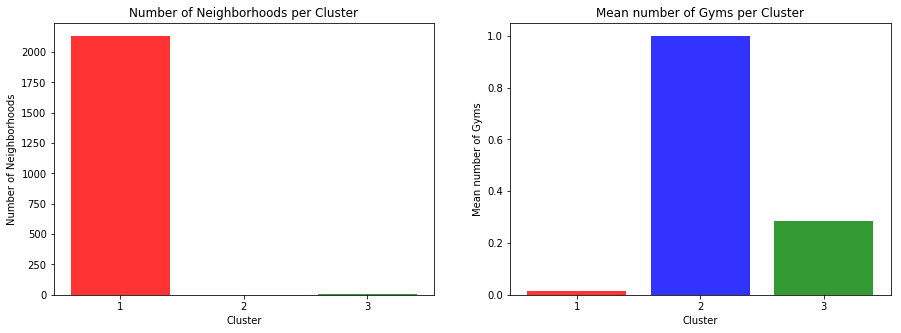

In [59]:
plt.figure(figsize=(15,5))

# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
objects = (1,2,3)
y_pos = np.arange(len(objects))
performance = gyms['Cluster'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['red', 'blue','green'])
plt.xticks(y_pos, objects)
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Italian Restaurants per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [cluster_1['Gym'].mean(),cluster_2['Gym'].mean(),cluster_3['Gym'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'blue','green'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean number of Gyms')
plt.xlabel('Cluster')
plt.title('Mean number of Gyms per Cluster')

We can see that in cluster 1, we have the largest number of neighborhoods with the lowest number of average gyms. We therefore select a neighborhood from cluster 1 to build a new gym in. One possible location to focus on is to the south of the map as it has a higher density of red dots. This could allow the gym to be in a more convenient location for these neighborhoods